In [ ]:
# Download Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark==3.3.2
# Next, we will install Apache Spark 3.0.1 with Hadoop 2.7 from here.
!wget https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
# Now, we just need to unzip that folder.
!tar xf spark-3.3.2-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
# Installing required packages
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 17.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824013 sha256=6a83b4562b5df0a0b794f31ae8cf16587b8f25d17f0af953dd4dd210372a907d
  Stored in directory: /root/.cache/pip/wheels/89/d6/52/1178e354ba2207673484f0ccd7b2ded0ab6671ae5c1fc5b49a
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
--2023-05-17 23:40:56--  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... conn

In [ ]:
import findspark
import ipywidgets as widgets
from google.colab import files

#findspark.init()
# Importar las librerías necesarias
from pyspark.sql import SparkSession
import pyspark.ml as ml
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as fct
import os
import io
import pandas as pd
import pyspark.ml as ml
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

# Crear una sesión de Spark
spark = SparkSession.builder.appName("Clasificacion de Noticias").getOrCreate()

# Cargar los datos desde el archivo CSV
data =  spark.read.format("csv").option("header", "true").load("/content/BBC News Train.csv")
(training_data, test_data) = data.randomSplit([0.7, 0.3], seed=100)

# Convertir los datos a un formato adecuado para Spark ML
tokenizer = Tokenizer(inputCol="Text", outputCol="palabras")
remover_stopwords = StopWordsRemover(inputCol="palabras", outputCol="palabras_sin_stopwords")
vectorizer = CountVectorizer(inputCol="palabras_sin_stopwords", outputCol="features")
idf = IDF(inputCol="features", outputCol="tf_idf")
stringIndexer = ml.feature.StringIndexer(inputCol="Category", outputCol="ordinal_Category", stringOrderType="alphabetAsc")
naive_bayes = NaiveBayes(labelCol="ordinal_Category", featuresCol="tf_idf")

preprocess_pipeline = ml.Pipeline(stages=[tokenizer,remover_stopwords,vectorizer,idf,stringIndexer,naive_bayes])

In [ ]:
##diccionario para categorias
dictionary_category={
    0:'bussines',
    1:'entertainment',
    2:'politics',
    3:'sports',
    4:'tech'
}

In [ ]:
#entrenamiento
modelo = preprocess_pipeline.fit(training_data)

# Realizar predicciones sobre el conjunto de prueba
predicciones = modelo.transform(test_data)


In [ ]:
# Evaluar la precisión del modelo
evaluador = MulticlassClassificationEvaluator(labelCol="ordinal_Category", predictionCol="prediction", metricName="accuracy")
f_score = []
for i in range(0,5):
  f_score.append((MulticlassClassificationEvaluator(labelCol="ordinal_Category", predictionCol="prediction", metricName="fMeasureByLabel",metricLabel=i)).evaluate(predicciones))
precision = evaluador.evaluate(predicciones)
print("Precision:", precision)
print("F_score:", f_score)


Precision: 0.9678899082568807
F_score: [0.9509803921568627, 0.975, 0.9534883720930233, 0.9942857142857142, 0.968944099378882]


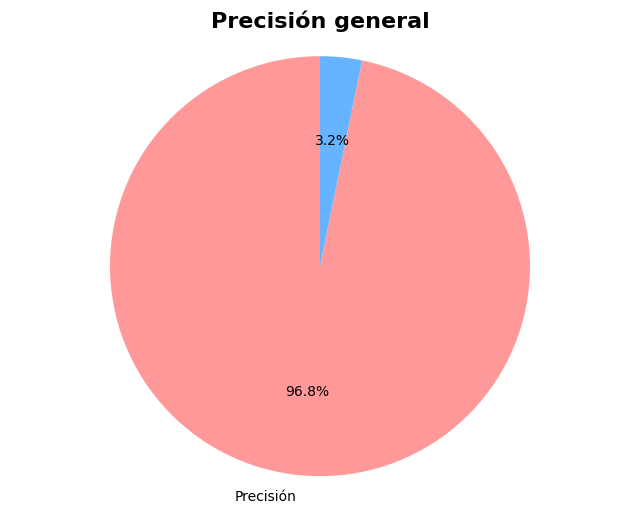

In [ ]:
# Datos a graficar
etiquetas = ['Precisión', '']
valores = [precision*100, (1-precision)*100]
colores = ['#ff9999','#66b3ff']

# Crear el gráfico de torta con matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(valores, labels=etiquetas, colors=colores, autopct='%1.1f%%', startangle=90)

# Ajustar el estilo del gráfico
ax.axis('equal')
ax.set_title('Precisión general', fontsize=16, fontweight='bold')

# Mostrar el gráfico
plt.show()

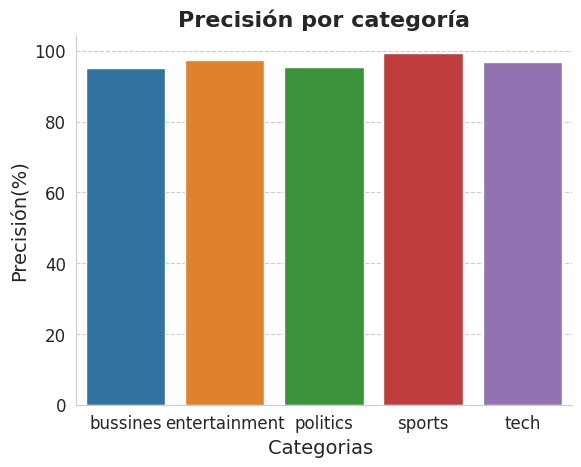

In [ ]:
# Datos a graficar
etiquetas = [dictionary_category[0], dictionary_category[1], dictionary_category[2], dictionary_category[3], dictionary_category[4]]
valores = [f_score[0]*100, f_score[1]*100, f_score[2]*100, f_score[3]*100, f_score[4]*100]
sns.set_style('whitegrid')
fig, ax = plt.subplots()
ax = sns.barplot(x=etiquetas, y=valores)

# Añadir título y etiquetas a los ejes
sns.despine()
ax.set_title('Precisión por categoría', fontsize=16, fontweight='bold')
ax.set_xlabel('Categorias ', fontsize=14)
ax.set_ylabel('Precisión(%)', fontsize=14)
ax.tick_params(labelsize=12)
ax.grid(axis='y', linestyle='--')
# Mostrar el gráfico
plt.show()


In [ ]:
# Función que se ejecuta cuando se selecciona un archivo
def on_file_upload(change):
    # Obtener el nombre del archivo y el contenido
    filename = next(iter(change.new))
    content = change.new[filename]['content']

    # Guardar el archivo en el entorno de Colab
    with open(filename, 'wb') as file:
        file.write(content)

    # Obtener la ruta absoluta del archivo
    file_path = os.path.abspath(filename)
    print(f"El archivo '{filename}' se ha guardado en el entorno de Colab.")
    test = spark.read.format("csv").option("header", "true").load(file_path)
    predicciones_test = modelo.transform(test)
    prediction_rdd = predicciones_test.rdd.map(lambda x: (x.ArticleId,x.Text,dictionary_category[x.prediction])).collect()
    prediction_df = spark.createDataFrame(prediction_rdd, schema = ["ArticleId","Text","Category_prediction"])
    prediction_df.show()
    countr = prediction_df.groupby(prediction_df.Category_prediction).count()
    countr.show()
 



# Crear el botón de carga
upload_button = widgets.FileUpload(description='Cargar archivo',accept='.csv', multiple=False)

# Asignar la función on_file_upload al botón
upload_button.observe(on_file_upload, names=['value'])

# Mostrar el botón en el notebook
display(upload_button)

FileUpload(value={}, accept='.csv', description='Cargar archivo')

El archivo 'BBC News Test.csv' se ha guardado en el entorno de Colab.
+---------+--------------------+-------------------+
|ArticleId|                Text|Category_prediction|
+---------+--------------------+-------------------+
|     1018|qpr keeper day he...|             sports|
|     1319|software watching...|               tech|
|     1138|d arcy injury add...|             sports|
|      459|india s reliance ...|           bussines|
|     1020|boro suffer morri...|             sports|
|       51|lewsey puzzle ove...|             sports|
|     2025|blair blasts tory...|           politics|
|     1479|former ni ministe...|           politics|
|       27|career honour for...|      entertainment|
|      397|tsunami  to hit s...|           bussines|
|     1644|us economy still ...|           bussines|
|      263|digital uk driven...|               tech|
|      765|blunkett tells of...|           politics|
|     2134|ibm puts cash beh...|               tech|
|      297|cage film s third.

In [ ]:
input_file = list(upload_button.value.values())[0]
content = input_file['content']
content = io.StringIO(content.decode('utf-8'))
df = pd.read_csv(content)
df.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
